In [1]:
from diffusers import AutoPipelineForText2Image, DiffusionPipeline, ImagePipelineOutput
import torch
from typing import List, Tuple
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-2-2222348421>:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (1, pipe.unet.in_channels, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)


torch.Size([1, 77, 768]) torch.Size([1, 77, 768])


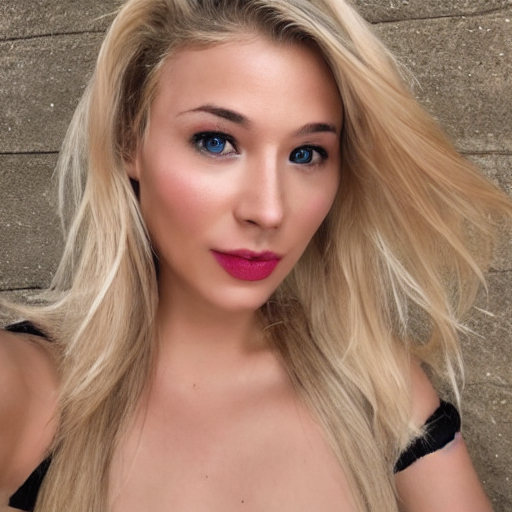

In [2]:
@torch.no_grad()
def run_composed_diffusion_sd(
    pipe: DiffusionPipeline,
    prompt: str,
    composition_scale: float = 1.0,
    num_inference_steps: int = 50,
    height: int = 512,
    width: int = 512,
    generator: torch.Generator | None = None,
) -> Image.Image:

    device = pipe._execution_device
    dtype  = pipe.unet.dtype  # usually float16

    latents_shape = (1, pipe.unet.in_channels, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)
    if generator is None:
        generator = torch.Generator(device).manual_seed(31)
    latents = torch.randn(latents_shape, generator=generator, device=device, dtype=dtype)

    uncond_ids = pipe.tokenizer(
        [""], padding="max_length",
        max_length=pipe.tokenizer.model_max_length, return_tensors="pt"
    ).to(device)

    cond_ids  = pipe.tokenizer(
        [prompt], padding="max_length", truncation=True,
        max_length=pipe.tokenizer.model_max_length, return_tensors="pt"
    ).to(device)

    emb_uncond = pipe.text_encoder(uncond_ids.input_ids)[0]
    emb_cond   = pipe.text_encoder(cond_ids.input_ids)[0]

    print(emb_uncond.shape, emb_cond.shape)
    text_embeds = torch.cat([emb_uncond, emb_cond], dim=0).to(device, dtype)

    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    for t in pipe.scheduler.timesteps:
        latent_in = latents.repeat(2, 1, 1, 1)                 # 2 batches = [ε , ε_cond]
        latent_in = pipe.scheduler.scale_model_input(latent_in, t)

        noise_pred_uncond, noise_pred_cond = pipe.unet(
            latent_in, t, encoder_hidden_states=text_embeds
        ).sample.chunk(2)

        eps = noise_pred_uncond + composition_scale * (noise_pred_cond - noise_pred_uncond)
        latents = pipe.scheduler.step(eps, t, latents).prev_sample

    imgs = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
    img  = (imgs[0] / 2 + 0.5).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((img * 255).astype("uint8"))


pipe = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
image = run_composed_diffusion_sd(pipe, "a female without glasses blonde hair", composition_scale=7.51)
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-3-4072269301>:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (1, pipe.unet.in_channels, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)


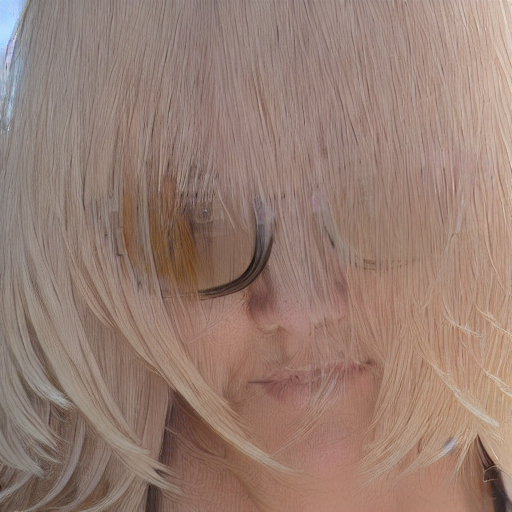

In [3]:
def _parse_prompt(prompt: str, composition_scale: float):
    """Return
       pos_concepts : list[str]           (plain conjunction terms)
       neg_pairs    : list[tuple[str,str]] [(c_pos , c_neg)]
       w_pos, w_neg : list[float]         (same length as the two lists)
    """
    pos_concepts, neg_pairs, w_pos, w_neg = [], [], [], []
    for p in [q.strip() for q in prompt.split("|") if q.strip()]:
        if p.lower().startswith(("without ", "not ")):      # negation
            c_pos = p.split(" ", 1)[1].strip()
            neg_pairs.append((c_pos, p))
            w_neg.append(composition_scale)
        else:                                               # plain “AND”
            pos_concepts.append(p)
            w_pos.append(composition_scale)
    return pos_concepts, neg_pairs, w_pos, w_neg

@torch.no_grad()
def run_composed_diffusion_sd_2(
    pipe: DiffusionPipeline,
    prompt: str,
    composition_scale: float = 1.0,
    num_inference_steps: int = 500,
    height: int = 512,
    width: int = 512,
    generator: torch.Generator | None = None,
) -> Image.Image:

    device = pipe._execution_device
    dtype  = pipe.unet.dtype  # usually float16

    pos_concepts, neg_pairs, w_pos, w_neg = _parse_prompt(prompt, composition_scale)
    all_prompts = [""] + pos_concepts + [c for pair in neg_pairs for c in pair]

    tok = pipe.tokenizer(all_prompts,
                        padding="max_length",
                        truncation=True,
                        return_tensors="pt").to(device)
    text_embeds = pipe.text_encoder(**tok).last_hidden_state.to(device, dtype)

    latents_shape = (1, pipe.unet.in_channels, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)
    if generator is None:
        generator = torch.Generator(device).manual_seed(31)
    latents = torch.randn(latents_shape, generator=generator, device=device, dtype=dtype)

    n_total = text_embeds.shape[0]

    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    for t in pipe.scheduler.timesteps:
        # (3.1) duplicate the latents so UNet sees every conditioning batch
        latent_in = latents.repeat(n_total, 1, 1, 1)
        latent_in = pipe.scheduler.scale_model_input(latent_in, t)

        # (3.2) UNet forward for *all* prompts in one go
        noise_pred = pipe.unet(latent_in, t,
                              encoder_hidden_states=text_embeds).sample

        # (3.3) guidance-by-composition
        noise_pred_uncond = noise_pred[0]           # ε
        j, eps = 1, noise_pred_uncond.clone()

        # conjunction terms          ε += w (ε_i − ε)
        for w in w_pos:
            eps += w * (noise_pred[j] - noise_pred_uncond)
            j += 1

        # negation pairs             ε += w (ε_pos − ε_neg)
        for w in w_neg:
            eps += w * (noise_pred[j] - noise_pred[j + 1])
            j  += 2

        # (3.4) scheduler step
        latents = pipe.scheduler.step(eps, t, latents).prev_sample

    imgs = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
    img  = (imgs[0] / 2 + 0.5).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((img * 255).astype("uint8"))

pipe = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
prompt = "a female | without glasses | blonde hair"
image = run_composed_diffusion_sd_2(pipe, prompt, composition_scale=7.51)
image

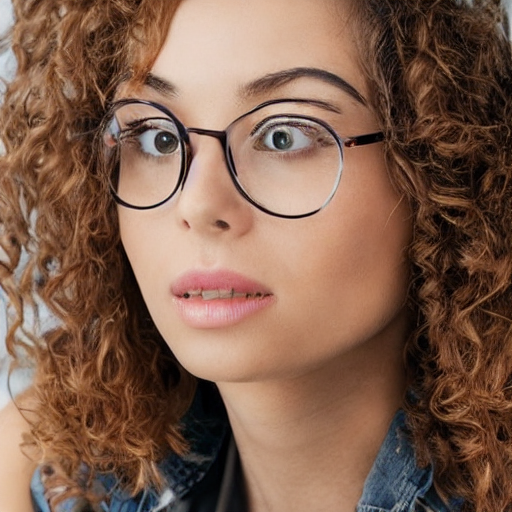

In [4]:
import torch
import numpy as np
from PIL import Image
from typing import List, Union, Optional, Tuple
from diffusers import DiffusionPipeline


@torch.no_grad()
def run_composable_diffusion_improved(
    pipe: DiffusionPipeline,
    prompts: List[str],
    weights: List[float],
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    height: int = 512,
    width: int = 512,
    generator: Optional[torch.Generator] = None,
    composition_mode: str = "and",  # "and", "or", "not"
    normalize_weights: bool = True,
    use_energy_guidance: bool = True,
) -> Image.Image:


    device = pipe._execution_device
    dtype = pipe.unet.dtype

    # Validate inputs
    if len(prompts) != len(weights):
        raise ValueError("Number of prompts must match number of weights")

    # Convert weights to tensor
    weights = torch.tensor(weights, device=device, dtype=dtype)
    if normalize_weights and len(weights) > 1:
        weights = weights / weights.abs().sum() * len(weights)

    # Initialize latents
    latents_shape = (
        1,
        pipe.unet.config.in_channels,
        height // pipe.vae_scale_factor,
        width // pipe.vae_scale_factor
    )

    if generator is None:
        generator = torch.Generator(device).manual_seed(42)

    latents = torch.randn(latents_shape, generator=generator, device=device, dtype=dtype)
    # Scale initial noise by scheduler's init_noise_sigma
    latents = latents * pipe.scheduler.init_noise_sigma

    # Set up scheduler
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # Prepare text embeddings
    text_embeddings = prepare_text_embeddings(pipe, prompts, device)
    uncond_embeddings = prepare_text_embeddings(pipe, [""], device)

    # Main denoising loop with composable guidance
    for i, t in enumerate(timesteps):
        # Expand latents for batch processing
        latent_model_input = torch.cat([latents] * (len(prompts) + 1))  # +1 for unconditional
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Prepare embeddings (unconditional + all conditionals)
        embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Get noise predictions
        with torch.no_grad():
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=embeddings,
                return_dict=False,
            )[0]

        # Split predictions
        noise_pred_uncond = noise_pred[:1]
        noise_pred_conds = noise_pred[1:]

        # Apply composable guidance
        if use_energy_guidance:
            composed_noise_pred = apply_energy_based_composition(
                noise_pred_uncond,
                noise_pred_conds,
                weights,
                composition_mode,
                guidance_scale
            )
        else:
            composed_noise_pred = apply_weighted_composition(
                noise_pred_uncond,
                noise_pred_conds,
                weights,
                guidance_scale
            )

        # Scheduler step (without generator as it's not supported by all schedulers)
        latents = pipe.scheduler.step(composed_noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = 1 / pipe.vae.config.scaling_factor * latents
    with torch.no_grad():
        images = pipe.vae.decode(latents).sample

    # Convert to PIL Image
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).float().numpy()
    images = (images * 255).round().astype("uint8")

    return Image.fromarray(images[0])


def prepare_text_embeddings(pipe, prompts: List[str], device) -> torch.Tensor:
    """Prepare text embeddings for given prompts"""
    text_inputs = pipe.tokenizer(
        prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_inputs.input_ids.to(device))[0]

    return text_embeddings


def apply_energy_based_composition(
    noise_pred_uncond: torch.Tensor,
    noise_pred_conds: torch.Tensor,
    weights: torch.Tensor,
    composition_mode: str,
    guidance_scale: float
) -> torch.Tensor:

    if composition_mode == "and":
        composed_cond = torch.zeros_like(noise_pred_uncond)

        total_weight = 0
        for i, weight in enumerate(weights):
            if weight != 0:
                # Energy-based combination
                composed_cond += weight * noise_pred_conds[i:i+1]
                total_weight += abs(weight)

        # Normalize to maintain reasonable scale
        if total_weight > 0:
            composed_cond = composed_cond / total_weight

    elif composition_mode == "or":
        weighted_preds = []
        for i, weight in enumerate(weights):
            if weight != 0:
                weighted_preds.append(weight * noise_pred_conds[i:i+1])

        if weighted_preds:
            # Smooth max approximation using log-sum-exp
            stacked_preds = torch.stack(weighted_preds, dim=0)
            composed_cond = torch.logsumexp(stacked_preds, dim=0) - np.log(len(weighted_preds))
        else:
            composed_cond = torch.zeros_like(noise_pred_uncond)

    elif composition_mode == "not":
        # Negation: subtract negative concepts from positive ones
        positive_cond = torch.zeros_like(noise_pred_uncond)
        negative_cond = torch.zeros_like(noise_pred_uncond)

        pos_count = 0
        neg_count = 0

        for i, weight in enumerate(weights):
            if weight > 0:
                positive_cond += weight * noise_pred_conds[i:i+1]
                pos_count += 1
            elif weight < 0:
                negative_cond += abs(weight) * noise_pred_conds[i:i+1]
                neg_count += 1

        # Normalize each component
        if pos_count > 0:
            positive_cond = positive_cond / pos_count
        if neg_count > 0:
            negative_cond = negative_cond / neg_count

        # Energy-based negation: E_composed = E_positive - E_negative
        composed_cond = positive_cond - negative_cond

    else:
        # Default: weighted average
        return apply_weighted_composition(
            noise_pred_uncond, noise_pred_conds, weights, guidance_scale
        )

    # Apply classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (composed_cond - noise_pred_uncond)

    return noise_pred


def apply_weighted_composition(
    noise_pred_uncond: torch.Tensor,
    noise_pred_conds: torch.Tensor,
    weights: torch.Tensor,
    guidance_scale: float
) -> torch.Tensor:
    """Simple weighted composition (fallback method)"""

    # Weighted combination of conditional predictions
    composed_cond = torch.zeros_like(noise_pred_uncond)
    total_weight = 0

    for i, weight in enumerate(weights):
        if weight != 0:
            composed_cond += weight * noise_pred_conds[i:i+1]
            total_weight += abs(weight)

    if total_weight > 0:
        composed_cond = composed_cond / total_weight

    # Apply classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (composed_cond - noise_pred_uncond)

    return noise_pred


# Additional utility functions for advanced composition

def parse_composite_prompt(prompt: str) -> Tuple[List[str], List[float], str]:

    # Simple parsing logic - you can extend this
    if " AND " in prompt.upper():
        parts = [p.strip() for p in prompt.split(" AND ")]
        return parts, [1.0] * len(parts), "and"
    elif " OR " in prompt.upper():
        parts = [p.strip() for p in prompt.split(" OR ")]
        return parts, [1.0] * len(parts), "or"
    elif " NOT " in prompt.upper():
        parts = prompt.split(" NOT ", 1)
        positive = parts[0].strip()
        negative = parts[1].strip()
        return [positive, negative], [1.0, -1.0], "not"
    elif "|" in prompt:
        parts = [p.strip() for p in prompt.split("|")]
        prompts = []
        weights = []

        for part in parts:
            if part.lower().startswith("not ") or part.lower().startswith("without "):
                # Negative concept
                concept = part.split(" ", 1)[1] if " " in part else part
                prompts.append(concept)
                weights.append(-1.0)
            else:
                # Positive concept
                prompts.append(part)
                weights.append(1.0)

        return prompts, weights, "and"
    else:
        return [prompt], [1.0], "and"


# Convenience function with automatic prompt parsing
@torch.no_grad()
def generate_composed_image(
    pipe: DiffusionPipeline,
    prompt: str,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    height: int = 512,
    width: int = 512,
    generator: Optional[torch.Generator] = None,
    use_energy_guidance: bool = True,
) -> Image.Image:


    prompts, weights, composition_mode = parse_composite_prompt(prompt)

    return run_composable_diffusion_improved(
        pipe=pipe,
        prompts=prompts,
        weights=weights,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        generator=generator,
        composition_mode=composition_mode,
        use_energy_guidance=use_energy_guidance,
    )


# Simpler, more robust implementation (closer to your original)
@torch.no_grad()
def generate_composed_image_simple(
    pipe: DiffusionPipeline,
    prompts: List[str],
    weights: List[float],
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    height: int = 512,
    width: int = 512,
    generator: Optional[torch.Generator] = None,
) -> Image.Image:

    device = pipe._execution_device
    dtype = pipe.unet.dtype

    # Validate inputs
    if len(prompts) != len(weights):
        raise ValueError("Number of prompts must match number of weights")

    # Initialize latents
    latents_shape = (
        1,
        pipe.unet.config.in_channels,
        height // pipe.vae_scale_factor,
        width // pipe.vae_scale_factor
    )

    if generator is None:
        generator = torch.Generator(device).manual_seed(42)

    latents = torch.randn(latents_shape, generator=generator, device=device, dtype=dtype)
    latents = latents * pipe.scheduler.init_noise_sigma

    # Set up scheduler
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # Prepare text embeddings
    text_embeddings = prepare_text_embeddings(pipe, prompts, device)
    uncond_embeddings = prepare_text_embeddings(pipe, [""], device)

    # Main denoising loop
    for i, t in enumerate(timesteps):
        # Predict noise for unconditional
        latent_input = pipe.scheduler.scale_model_input(latents, t)
        with torch.no_grad():
            noise_pred_uncond = pipe.unet(
                latent_input,
                t,
                encoder_hidden_states=uncond_embeddings,
                return_dict=False,
            )[0]

        # Predict noise for each conditional prompt
        noise_pred_conds = []
        for j, embedding in enumerate(text_embeddings):
            with torch.no_grad():
                noise_pred = pipe.unet(
                    latent_input,
                    t,
                    encoder_hidden_states=embedding.unsqueeze(0),
                    return_dict=False,
                )[0]
            noise_pred_conds.append(noise_pred)

        # Compose the predictions
        composed_noise_pred = noise_pred_uncond.clone()

        for j, (noise_pred_cond, weight) in enumerate(zip(noise_pred_conds, weights)):
            if weight != 0:
                # Apply guidance similar to classifier-free guidance
                composed_noise_pred += weight * guidance_scale * (noise_pred_cond - noise_pred_uncond) / len(weights)

        # Scheduler step
        latents = pipe.scheduler.step(composed_noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = 1 / pipe.vae.config.scaling_factor * latents
    with torch.no_grad():
        images = pipe.vae.decode(latents).sample

    # Convert to PIL Image
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).float().numpy()
    images = (images * 255).round().astype("uint8")

    return Image.fromarray(images[0])


"""
from diffusers import StableDiffusionPipeline

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Simple usage - this should work reliably
image = generate_composed_image_simple(
    pipe=pipe,
    prompts=["cat", "dog"],
    weights=[1.0, 1.0]
)

# With negation
image = generate_composed_image_simple(
    pipe=pipe,
    prompts=["beautiful landscape", "urban"],
    weights=[1.0, -0.5]  # landscape but less urban
)
"""
# Use this simpler version first to test
# image = generate_composed_image_simple(
#     pipe=pipe,
#     prompts=["cat", "dog"],
#     weights=[1.0, 10.0]
# )
# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     torch_dtype=torch.float16
# ).to("cuda")

image = generate_composed_image_simple(
    pipe=pipe,
    prompts=["woman", " glasses", "hair"],
    weights=[1.0, 1.0, 1.0]
)
image